In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import Functions

In [2]:
from SCC_functions import *
from MAC_functions import *
from emissions_functions import *

## Define Parameters

MACC parameters

In [3]:
# default settings
P0 = 50
P_50 = 120
P_100 = 300
s = 0.05
r = 0.03
# P_50=356.69970703125
# s=0.07500000000000001
# r=0.025
# P_100=484.6875

Years Parameters

In [4]:
start_year = 2020
end_year = 3000

In [5]:
first_perturbed_year = start_year
last_perturbed_year = 2500

Initial Temperature Anomaly

In [6]:
T_0 = 1.2

Initial Temperature Profile Parameters

In [7]:
# delta_T = 1.5
delta_T = 1.2
alpha = 0.02

Consumption Growth Parameters

In [8]:
consumption_growth = 0.01

In [9]:
consumption_discount = consumption_growth + 0.015

SCC Calculation Parameters

In [10]:
T_TCRE_1 = 0.00045
k_s = 0.12
size_of_perturbation = 1 ## in GtCO2

In [11]:
gamma = 6
D0 = 0.00236

CO2 baseline

In [12]:
CO2_baseline = 40

# Steps

## Create array of years, initial temperature profile, and consumption time series

In [13]:
years = create_years_array(start_year, end_year)
num_of_years = len(years)

In [14]:
years_of_perturbation = create_years_array(start_year, last_perturbed_year)

In [15]:
T_ts = create_geometric_T(years, T_0=T_0, alpha=alpha, delta_T=delta_T)

Text(0, 0.5, 'Temperature Anomaly ($^{\\circ}$C)')

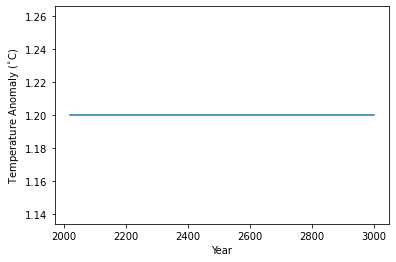

In [16]:
plt.plot(years, T_ts)
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly ($^{\circ}$C)")

In [17]:
W_ts = create_total_consumption(years, W_fixed_year=2020, W_fixed=80, consumption_growth=consumption_growth)

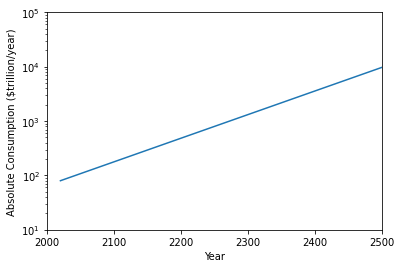

In [18]:
plt.plot(years, W_ts)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
plt.xlim(2000, 2500)
plt.ylim(10, 100000)
plt.yscale("log")

## Iteration Loop

In [19]:
def T_iteration_loop(T_ts):
    SCC_ts_to_P_100 = []
    for SCC_year in range(len(years_of_perturbation)):
        W_ts = create_total_consumption(years, consumption_growth=consumption_growth)
        discount_function_ts = create_discount_function(years, SCC_year=years_of_perturbation[SCC_year],
                                                        consumption_discount=consumption_discount)
        T_perturbed_ts = create_geometric_T_perturbed(years, T=T_ts, SCC_year=years_of_perturbation[SCC_year],
                                                        T_TCRE=T_TCRE_1 * size_of_perturbation, k_s=k_s)

        time_series_data = {'years': years, 'W': W_ts, 'discount function': discount_function_ts,
                            'T': T_ts, 'T perturbed': T_perturbed_ts}
        time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

        SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)
        if SCC_year == 0:
            SCC_0 = SCC

        SCC_adjusted = SCC - SCC_0 + P0

        if SCC_adjusted < P_100:
            SCC_ts_to_P_100.append(SCC_adjusted)
        else:
            SCC_ts_to_P_100.append(P_100)
            break

    SCC_ts = forecast_SCC(SCC_ts_to_P_100, years)

    abatement_ts = abatement(P=SCC_ts, P0=P0, P_50=P_50, s=s, P_100=P_100, r=r)
    emissions_ts = abatement_to_emissions(abatement_ts, CO2_baseline)
    cumulative_emissions_array = calculate_cumulative_emissions(emissions_ts)
    temperature_change = T_TCRE_1 * cumulative_emissions_array

    T_ts = T_0 + temperature_change
    return T_ts

### First Loop

In [20]:
T_ts_1 = T_iteration_loop(T_ts)

/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calc/MAC_functions.py:10: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


In [21]:
T_ts_2 = T_iteration_loop(T_ts_1)

In [22]:
T_ts_av = (T_ts_1+T_ts_2)/2

2.4481539523896587 1.258077520540111 1.853115736464885


Text(0, 0.5, 'Temperature Anomaly ($^{\\circ}$C)')

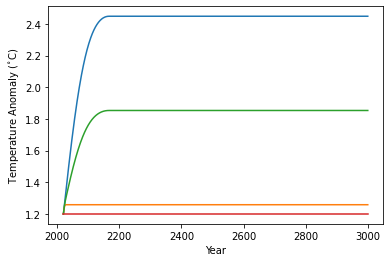

In [23]:
plt.plot(years, T_ts_1)
plt.plot(years, T_ts_2)
plt.plot(years, T_ts_av)
plt.plot(years, T_ts)
print(max(T_ts_1), max(T_ts_2), max(T_ts_av))
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly ($^{\circ}$C)")

### Further Loops

/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calc/MAC_functions.py:10: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calc/MAC_functions.py:10: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calc/MAC_functions.py:10: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calc/MAC_functions.py:10: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/Users/aaron/Documents/oxford_physics/Year_4/MPhys/drivers-of-peak-warming/peak_warming_calc/MAC_functions.py:10: RuntimeWar

6
1.5627529755157716


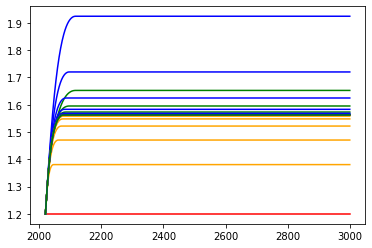

In [24]:
max_1 = [max(T_ts_1)]
max_2 = [max(T_ts_2)]
max_av = [max(T_ts_av)]
# plt.plot(years, T_ts_1, color="blue")
# plt.plot(years, T_ts_2, color="orange")
# plt.plot(years, T_ts_av, color="green")
plt.plot(years, T_ts, color="red")

num_of_iterations = 9

for i in range(num_of_iterations):
    T_ts_1 = T_iteration_loop(T_ts_av)
    T_ts_2 = T_iteration_loop(T_ts_1)
    T_ts_av = (T_ts_1+T_ts_2)/2
    
    max_1.append(max(T_ts_1))
    max_2.append(max(T_ts_2))
    max_av.append(max(T_ts_av))
    
    plt.plot(years, T_ts_1, color="orange")
    plt.plot(years, T_ts_2, color="blue")
    plt.plot(years, T_ts_av, color="green")
#     plt.plot(years, T_ts_1)
#     plt.plot(years, T_ts_2)
    
    if abs(max(T_ts_1)-max(T_ts_2)) < 0.001:
        print(i)
        print(max(T_ts_2))
        break
    

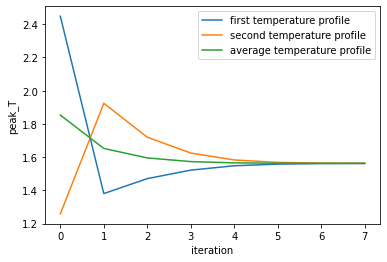

In [29]:
plt.plot(max_1, label = "first temperature profile")
plt.plot(max_2, label = "second temperature profile")
plt.plot(max_av, label = "average temperature profile")
plt.xlabel("iteration")
plt.ylabel("peak_T")
plt.legend()